<a href="https://colab.research.google.com/github/eddy123457/Predicting_MMR_Hotspots/blob/main/HotSpots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [ ]:
import google, importlib
pkgs = {
    'numpy':'1.26.3',
    'pandas':'2.1.4',
    'pandas_gbq':'0.20.0',
    'ipython-autotime':'0.3.0',
    'scikit-learn':'1.4.1',
    'flaml':'2.1.2',
    'miceforest':'5.7.0',
    'missingno':'0.5.2',
    'seaborn':'0.13.1',
    'plotly':'5.20.0',
    'epiweeks':'2.3.0',
    }
if not all(importlib.metadata.version(nm) >= ver for nm, ver in pkgs.items()):
    ! pip install -U {' '.join(pkgs.keys())} # update if necessary
    ! pip install -U flaml[automl,catboost,notebook]
    ! pip install -U skopt[plots]
    google.colab.output.clear() # clear messy output from update process
    get_ipython().kernel.do_shutdown(True) # restart runtime so updates take effect - ignore the "session crashed" pop-up

In [ ]:
variable_name = ""
%reload_ext autotime
%reload_ext google.colab.data_table
import google, numpy as np, pandas as pd, pandas_gbq
google.colab.drive.mount('/content/drive')
google.colab.auth.authenticate_user()

solutions = dict()
def run_qry(qry, show=False, **kwargs):
    kwargs['project_id'] = 'tarletondatascience2022'
    if show:
        print(qry)
    return pandas_gbq.read_gbq(qry, **kwargs)

def indent(qry, lev=1):
    t = '    ' * lev
    return t + qry.strip().replace('\n','\n'+t)

def subqry(qry, lev=1):
    return indent('from (',lev-1) + '\n' + indent(qry,lev) + '\n' + indent(')',lev-1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.81 s (started: 2024-04-30 16:57:24 +00:00)


# Introduction and Goal

So, the goal of the project is to be able to predict disease hot spots in America. So in order to accomplish this we begin by joining two datasets. The first is one that is one named usa_contagious_disease from bigquery it contains information on a weekly bases from 1916-2011. The second is a data set that is from the US Census database with information from 1910-2020.

<br>

The project later shfited after a meeting with you where I realized that it made more sense to predict a certain disease rather than try and use every disease in this set. With that being said I then shifted to predicting on the MMR ('Meseals' , 'Mumps' , 'Rubella').

<br>

---





First lets read in the usa_contagious_disease dataset. This data set has these features [epi_week,	state	loc	,loc_type, disease,	cases,	incidence_per_100000]

<br>

ill go ahead and list the important features

<br>


epi_week: is a standard set by the CDC to mark certain weeks in the year

disease: there are various dieaseses in this set

<br>

---



In [ ]:
# @title Sql Qry
qry = f"""
select
    A.*
from
  bigquery-public-data.usa_contagious_disease.project_tycho_reports A"""

df=run_qry(qry=qry, show=False)

#display(df)
# I use this to save files without having to run from the start everyday. There are better file types but I like to have my set visible while I work on it

df.to_csv('usa_contagious_disease.csv', index=False)

Now for the second dataset. I have downloaded a file from the Census database in order to work with it for the project.


<br>


The set has population density information for each state and the United States as a whole. In addtion the file containts more information like representatives in certain areas and how many people they represent. For the purposes of this project we dont need any of that information.

<br>

We will use features like [
    'Resident Population',
    'Percent Change in Resident Population',
    'Resident Population Density',
]

This will show the model a couple things that are important when using population desnity.

1.   How many people are in the area? raw and density forms
2.   Whats the percentage of change for the people in the area?




---



In [ ]:
# @title Preprocessing and Joining
from datetime import datetime, timedelta
#so we have to convert the epiweeks to just weeks this is before i realized there was a library made for this I spent at least a week trying to fidgure out the formula for this.
#I did confim this worked by taking epiweeks on the CDC site that i knew the output for
def epi_convert(epi_week):
    year = int(str(epi_week)[:4])
    week = int(str(epi_week)[4:])

    firstDyear = datetime(year, 1, 1)

    #have to make sure monday is first day of the week
    if firstDyear.weekday() <= 3:  # Th or earlier that week is week 1
        day = (week - 1) * 7 - firstDyear.weekday()
    else:  #Fri or later week 1 starts next week
        day = (week - 1) * 7 - firstDyear.weekday() + 7

    start = firstDyear + timedelta(days=day)
    end = start + timedelta(days=6)

    return start, end

data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/usa_contagious_disease.csv')
data_density=pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/populationdensity.csv')

drop = [col for col in data_density.columns if "Representative" in col]
data_density = data_density.drop(columns=drop)
data_density['Name'] = data_density['Name'].str.upper()
#conversion and setting a start and end date for the weeks
data['start_date'], data['end_date'] = zip(*data['epi_week'].apply(epi_convert))

columns_order = ['epi_week', 'start_date', 'end_date', 'state', 'loc', 'loc_type', 'disease', 'cases', 'incidence_per_100000']
data_contagious = data[columns_order]
data_contagious['end_date'] = pd.to_datetime(data_contagious['end_date'])
data_contagious['end_year'] = data_contagious['end_date'].dt.year
#data_contagious.head()

merge_data = pd.merge(left=data_contagious, right=data_density, how='inner', left_on='loc', right_on='Name')
merge_data = merge_data[merge_data['Year'] == merge_data['end_year']]



merge_data = merge_data.replace('\\N', np.nan) #replace the blank spaces with a nan

cols = [
    'Resident Population',
    'Percent Change in Resident Population',
    'Resident Population Density',
]

for c in cols:
    merge_data[c] = pd.to_numeric(merge_data[c].astype(str).str.replace(',', ''), errors='coerce')

ccols = ['state','disease']
merge_data = pd.get_dummies(merge_data, columns=ccols)

display(merge_data)

merge_data.to_csv('/content/drive/MyDrive/project/capstone/joined_data.csv', index=False)


,epi_week,start_date,end_date,loc,loc_type,cases,incidence_per_100000,end_year,Name,Geography Type,...,state_WV,state_WY,disease_DIPHTHERIA,disease_HEPATITIS A,disease_MEASLES,disease_MUMPS,disease_PERTUSSIS,disease_POLIO,disease_RUBELLA,disease_SMALLPOX
6,197006,1970-02-02,1970-02-08,ALASKA,STATE,0,0.00,1970,ALASKA,State,...,False,False,False,False,False,True,False,False,False,False
18,197007,1970-02-09,1970-02-15,ALASKA,STATE,0,0.00,1970,ALASKA,State,...,False,False,False,False,False,True,False,False,False,False
30,197008,1970-02-16,1970-02-22,ALASKA,STATE,0,0.00,1970,ALASKA,State,...,False,False,False,False,False,True,False,False,False,False
42,197012,1970-03-16,1970-03-22,ALASKA,STATE,0,0.00,1970,ALASKA,State,...,False,False,False,False,False,True,False,False,False,False
54,197020,1970-05-11,1970-05-17,ALASKA,STATE,0,0.00,1970,ALASKA,State,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7225304,199031,1990-07-30,1990-08-05,WYOMING,STATE,7,1.54,1990,WYOMING,State,...,False,True,False,True,False,False,False,False,False,False
7225316,199048,1990-11-26,1990-12-02,WYOMING,STATE,7,1.54,1990,WYOMING,State,...,False,True,False,True,False,False,False,False,False,False
7225364,199005,1990-01-29,1990-02-04,WYOMING,STATE,8,1.76,1990,WYOMING,State,...,False,True,False,True,False,False,False,False,False,False
7225448,199049,1990-12-03,1990-12-09,WYOMING,STATE,11,2.42,1990,WYOMING,State,...,False,True,False,True,False,False,False,False,False,False


time: 21.5 s (started: 2024-04-30 19:38:05 +00:00)


# Model building

So now that we have both sets joined together we can start to build the models.
<br>

 So, lets talk about how we plan to approach. At this point in time we are still targeting hotspots. But whats a hotspot?
 Well in this case we are classifying it as anything above the 75 quantile at a 100,000 incidence.

 In particular in these early models we are looking at

```
encodedcols = ['Year'] + [col for col in data.columns if col.startswith('disease_')]
X = data[encodedcols]
thres_hots = data['incidence_per_100000'].quantile(0.75)
y = (data['incidence_per_100000'] >= thres_hots).astype(int)
```
So, X is getting back all the encoded values which are the Year and disease types. And we are targeting those previously defined thresholds this is y.

 Important to note that the dataset is in epiweeks so it predicts as such as well. This means that our output will be predicted in weeks.


<br>

Why weeks if we specified 'Year' in encodedcols?

* Including Year allows us to track periods of time better then for instance week number 1000. In additon to helping the model learn.
<br>

Why not create multiple models with each year?
* Since we are not trying to predict just one year in advance this really doesnt make sense to do.


1.   Time is a factor when creating these models

2.   We want the model to learn year after year there isnt going to be drastic enough changes from year to year to justifty the individual models in the dataset we have




In [ ]:
# @title Model 1
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

data_path = '/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv'
data = pd.read_csv(data_path)

#there are so little missing values in this after the merge that intially i just used median. I know realize this still isnt the best option even in this case
data.fillna({'cases': 0, 'incidence_per_100000': 0, 'Resident Population': data['Resident Population'].median()}, inplace=True)

data['end_date'] = pd.to_datetime(data['end_date'])

#not needed at all but this is the first time I had attempted to transform a column
scaler = StandardScaler()
data[['cases', 'incidence_per_100000', 'Resident Population']] = scaler.fit_transform(data[['cases', 'incidence_per_100000', 'Resident Population']])

encodedcols = ['Year'] + [col for col in data.columns if col.startswith('disease_')]
X = data[encodedcols]

#hots spot threshold
thres_hots = data['incidence_per_100000'].quantile(0.75)
y = (data['incidence_per_100000'] >= thres_hots).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

#this is also the first time I felt the need to balance classes based on what I was getting previously
#this made me feel better than using SMOTE on potentially critical data like this

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Acc: {accuracy}")
print(classification_rep)


Acc: 0.8082991958731603
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      9884
           1       0.58      0.89      0.70      3298

    accuracy                           0.81     13182
   macro avg       0.77      0.84      0.78     13182
weighted avg       0.86      0.81      0.82     13182

time: 2.93 s (started: 2024-04-30 19:39:36 +00:00)


As we can see we have accomplished the goal! We are able to predict hotpots just like we intended to do. With an overall score of 81% we are well within a confortable range. However it seems that there can be some improvement in the areas of precision we can clearly see that the true column is under predictting. However, this can be attributed to the balancing of the weight classes. Lets see if we can sqweeze out some better results     

In [ ]:
# @title Model 2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
#everything is the same here but we are starting to use gridsearch I think this was after the intoduction to this in class
data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')
data.fillna({'cases': 0, 'incidence_per_100000': 0, 'Resident Population': data['Resident Population'].median()}, inplace=True)
data['end_date'] = pd.to_datetime(data['end_date'])

encodedcols = ['Year'] + [col for col in data.columns if col.startswith('disease_')]
X = data[encodedcols]
thres_hots = data['incidence_per_100000'].quantile(0.75)
y = (data['incidence_per_100000'] >= thres_hots).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=0))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Best Parameters: {best_params}\n")
print(f"Best Training Score: {best_score}\n")
print(f"Test Accuracy: {accuracy}\n")
print(classification_rep)


Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

Best Training Score: 0.8590068643708337

Test Accuracy: 0.8580640267030799

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      9884
           1       0.72      0.71      0.71      3298

    accuracy                           0.86     13182
   macro avg       0.81      0.81      0.81     13182
weighted avg       0.86      0.86      0.86     13182

time: 4min 27s (started: 2024-04-30 19:45:41 +00:00)


In [ ]:
# @title Model 3 this one has a NN takes 4 ever to run
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')
for column_name, series in data.items():
    if pd.api.types.is_string_dtype(series):
        data[column_name] = series.astype('category')
data.fillna({'cases': 0, 'incidence_per_100000': 0, 'Resident Population': data['Resident Population'].median()}, inplace=True)
data['end_date'] = pd.to_datetime(data['end_date'])

encodedcols = ['Year'] + [col for col in data.columns if col.startswith('disease_')]
X = data[encodedcols]
thres_hots = data['incidence_per_100000'].quantile(0.75)
y = (data['incidence_per_100000'] >= thres_hots).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier())
])

param_grid = [
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    {
        'classifier': [MLPClassifier(random_state=42, max_iter=300)],
        'classifier__hidden_layer_sizes': [(50,), (100,)],
        'classifier__activation': ['tanh', 'relu'],
        'classifier__solver': ['sgd', 'adam']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

bparameters = grid_search.best_params_
bscore = grid_search.best_score_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
class_rep = classification_report(y_test, y_pred)

print(f"Best Parameters: {bparameters}\n")
print(f"Best Training Score: {bscore}\n")
print(f"Test Accuracy: {acc}\n")
print(class_rep)


So overall we can see that we are able to predict with great accuracy. However, there is still room for improvment! As well as some contradictions.
1. We are assuming that all these diseases in this model have some thing in common for the model to learn from.

2. We want more consise results. So at the moment someone in Texas for example has no idea about the amount of hots spots in Texas alone. They would would only have access to the United States as a whole.

3. There is no way for them to know WHAT disease they should be anticipating in Texas

#Goal 2.0

Now we can tackle those issues in this new goal 2.0

<br>

Here are the updated goals

1.   Select a Common disease focus on
2.   Include the option to learn by state as well

okay, so we will select MMR also know as MUMPS, MEASLES and RUBELLA. These are typically grouped for many reasons however the main one being that they all share the same vaccine. Thus due to a vaccine being avaliable this was at one point thought to be erraaticated however due to a rise in antivaccines movements the disease has seen a resurgence. We will be looking to predict hotspots as before however now we intend to capture state data as well.

In [ ]:
# @title Model 1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import miceforest as mf
from flaml import AutoML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')
# this is for both the mice imputer and automl
for column_name, series in data.items():
    if pd.api.types.is_string_dtype(series):
        data[column_name] = series.astype('category')
#this almost the same but now we look for MMR the state aspect is not here yet at this point i had not realized i didnt have that
data['end_date'] = pd.to_datetime(data['end_date'])
thres_hots = data['incidence_per_100000'].quantile(0.75)

disease_columns = [col for col in data.columns if col.startswith('disease_') and ('MUMPS' in col.upper() or 'MEASLES' in col.upper() or 'RUBELLA' in col.upper())]
state_columns = [col for col in data.columns if 'Name' in col]

X = data[['Year'] + disease_columns + state_columns]
y = (data['incidence_per_100000'] >= thres_hots).astype(int)

actual_incidence_rates = data['incidence_per_100000'].values

kernel = mf.ImputationKernel(
    X,
    save_all_iterations=True,
    random_state=1991
)
kernel.mice(5)
# hadnt noticed i was training on only one set
X_imputed = kernel.complete_data(0)

automl = AutoML()

settings = {
    "time_budget": 10,
    "metric": 'f1',
    'verbose': 1,
    'split_type': 'stratified',
    "task": 'classification',
    "log_file_name": 'automl.log',
    'estimator_list': ['lgbm', 'rf', 'xgboost'],
    "early_stop": True,
    'hpo_method': 'cfo',
    "n_jobs": -1,
    'seed': 42,
    'n_splits': 3,
    "eval_method": 'cv',
    "ensemble": {
        "final_estimator": LogisticRegression(),
        "passthrough": True,
        "n_jobs": -1
    },
}

automl.fit(X_train=X_imputed, y_train=y, **settings)

best_model = automl.model
print(best_model)

y_pred = automl.predict(X_imputed)
print("Classification Report:")
print(classification_report(y, y_pred, target_names=['Not Hot Spot', 'Hot Spot']))

predicted_incidence_rates = np.where(y_pred == 1, actual_incidence_rates, 0) # not sure why this is red but still runs? small wins

predicted_sum = np.sum(predicted_incidence_rates)#got this idea from you

actual_sum = np.sum(actual_incidence_rates[y == 1])

total_error = predicted_sum - actual_sum
error_percentage = (total_error / actual_sum) * 100 if actual_sum != 0 else 0

print("Predicted Sum:", predicted_sum)
print("Actual Sum:", actual_sum)
print("Total Error:", total_error)
print("Error Percentage:", error_percentage)



#we can see that in the output I have a class unbalance based on recall score

StackingClassifier(estimators=[('lgbm',
                                <flaml.automl.model.LGBMEstimator object at 0x7a0972ea7bb0>),
                               ('xgboost',
                                <flaml.automl.model.XGBoostSklearnEstimator object at 0x7a093117a050>),
                               ('rf',
                                <flaml.automl.model.RandomForestEstimator object at 0x7a0931179fc0>)],
                   final_estimator=LogisticRegression(), n_jobs=-1)
Classification Report:
              precision    recall  f1-score   support

Not Hot Spot       0.80      0.98      0.88     49418
    Hot Spot       0.79      0.28      0.41     16490

    accuracy                           0.80     65908
   macro avg       0.80      0.63      0.64     65908
weighted avg       0.80      0.80      0.76     65908

Predicted Sum: 34507.950008541346
Actual Sum: 70842.6000096798
Total Error: -36334.65000113845
Error Percentage: -51.28926662230601
time: 17.8 s (started: 2024-

In [ ]:
# @title Model 2 takes about 3 min to run

#weekly not balanced
import pandas as pd
import numpy as np
from flaml import AutoML
import miceforest as mf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#seem familiar? I stole the idea from the amp project
def thisbetterwork(y, multiplier):
    return np.where(y == 1, multiplier, 1)

data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')
for column_name, series in data.items():
    if pd.api.types.is_string_dtype(series):
        data[column_name] = series.astype('category')

data['end_date'] = pd.to_datetime(data['end_date'])
thres_hots = data['incidence_per_100000'].quantile(0.75)
#now we incorporate state in the column 'name'
disease_columns = [col for col in data.columns if col.startswith('disease_') and ('MUMPS' in col.upper() or 'MEASLES' in col.upper() or 'RUBELLA' in col.upper())]
state_columns = [col for col in data.columns if 'Name' in col]

X = data[['Year'] + disease_columns + state_columns]
y = (data['incidence_per_100000'] >= thres_hots).astype(int)

kernel = mf.ImputationKernel(
    X,
    save_all_iterations=True,
    random_state=1991
)
kernel.mice(5)
#still not training on all the sets just havent noticed yet. I tend to copy and past the prev model and add on to it
X_imputed = kernel.complete_data(0)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
actual_incidence_rates_test = data.loc[X_test.index, 'incidence_per_100000']
#Also just stole this from our work on the project. In fact, after Id send you the email about a finding I would immediately apply to this project
best_error_percentage = float('inf')
best_multiplier = None
best_predictions = None

multiplier_range = np.arange(1.0, 4.0, 0.25)
for m in multiplier_range:
    sample_weights = thisbetterwork(y_train, m)

    automl = AutoML()
    settings = {
        "time_budget": 10,
        "metric": 'f1',
        'verbose': 1,
        'split_type': 'stratified',
        "task": 'classification',
        "log_file_name": 'automl.log',
        'estimator_list': ['lgbm', 'rf', 'xgboost'],
        "early_stop": True,
        'hpo_method': 'cfo',
        "n_jobs": -1,
        'seed': 42,
        'n_splits': 3,
        "eval_method": 'cv',
        "ensemble": {
            "final_estimator": LogisticRegression(),
            "passthrough": True,
            "n_jobs": -1
        },
    }
    automl.fit(X_train=X_train, y_train=y_train, sample_weight=sample_weights, **settings)

    y_pred = automl.predict(X_test)
    predicted_incidence_rates = np.where(y_pred == 1, actual_incidence_rates_test, 0)
    predicted_sum = np.sum(predicted_incidence_rates)
    actual_sum = np.sum(actual_incidence_rates_test[y_test == 1])

    total_error = predicted_sum - actual_sum
    error_percentage = (total_error / actual_sum) * 100 if actual_sum != 0 else 0
    #you said this wasnt needed but i didnt know that at the time
    if abs(error_percentage) < abs(best_error_percentage):
        best_error_percentage = error_percentage
        best_multiplier = m
        best_predictions = y_pred

print("Best Multiplier:", best_multiplier)
print("Best Error Percentage:", best_error_percentage)
print("Best Model Predictions:", len(best_predictions))
print("Classification Report:")
print(classification_report(y_test, best_predictions, target_names=['Not Hot Spot', 'Hot Spot']))

Best Multiplier: 3.0
Best Error Percentage: 0.32125702882439927
Best Model Predictions: 13182
Classification Report:
              precision    recall  f1-score   support

Not Hot Spot       0.96      0.75      0.84      9949
    Hot Spot       0.54      0.90      0.68      3233

    accuracy                           0.79     13182
   macro avg       0.75      0.83      0.76     13182
weighted avg       0.86      0.79      0.80     13182

time: 3min 14s (started: 2024-04-30 20:39:23 +00:00)


So dealing with the class imbalance: we se that the first model underpredicting severally. So wea want to give more weights to trues than false. We would much rather have resources allocated and have nothing happen then the opposite. Thats shown in the model with a 79 percent accuracy. We notice that the overall accuracy went down and thats because we want to adjust the weights and thats okay. we are misclassifying more often but this serves in our favor. This model is fine but we want to speed up the time frame a bit

# Final Model

In [ ]:
import pandas as pd
import numpy as np
from flaml import AutoML
import miceforest as mf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#caught on that i wasnt training by year any more so i dont have to find a weight so again took this from the project
def rf_bal(y):
    total_samples = len(y)
    class_counts = y.value_counts()
    class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}
    weights = y.map(class_weights)
    return weights.values, class_weights

data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')
for column_name, series in data.items():
    if pd.api.types.is_string_dtype(series):
        data[column_name] = series.astype('category')

data['end_date'] = pd.to_datetime(data['end_date'])
thres_hots = data['incidence_per_100000'].quantile(0.75)

disease_columns = [col for col in data.columns if col.startswith('disease_') and ('MUMPS' in col.upper() or 'MEASLES' in col.upper() or 'RUBELLA' in col.upper())]
state_columns = [col for col in data.columns if 'Name' in col]

X = data[['Year'] + disease_columns + state_columns]
y = (data['incidence_per_100000'] >= thres_hots).astype(int)

kernel = mf.ImputationKernel(
    X,
    save_all_iterations=True,
    random_state=1991
)
kernel.mice(5)

X_combined_train = pd.DataFrame()
y_combined_train = pd.Series()
#finally train by set
for i in range(5):
    X_imputed = kernel.complete_data(i)
    if i < 4:
        X_train, _, y_train, _ = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
        X_combined_train = pd.concat([X_combined_train, X_train])
        y_combined_train = pd.concat([y_combined_train, y_train])
    else:
        _, X_test, _, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

sample_weights, class_weights = rf_bal(y_combined_train)

automl = AutoML()
settings = {
    "time_budget": 10,
    "metric": 'f1',
    'verbose': 1,
    'split_type': 'stratified',
    "task": 'classification',
    "log_file_name": 'automl.log',
    'estimator_list': ['lgbm', 'rf', 'xgboost'],
    "early_stop": True,
    'hpo_method': 'cfo',
    "n_jobs": -1,
    'seed': 42,
    'n_splits': 3,
    "eval_method": 'cv',
    "ensemble": {
        "final_estimator": LogisticRegression(),
        "passthrough": True,
        "n_jobs": -1
    },
}
automl.fit(X_train=X_combined_train, y_train=y_combined_train, sample_weight=sample_weights, **settings)
y_pred = automl.predict(X_test)

best_score = np.mean(y_test == y_pred)
best_confusion = confusion_matrix(y_test, y_pred)

print(f"Best Score: {best_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

<ipython-input-40-a4e309ae5828>:47: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_combined_train = pd.concat([y_combined_train, y_train])


Best Score: 0.7946442118039752
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      9949
           1       0.55      0.88      0.68      3233

    accuracy                           0.79     13182
   macro avg       0.75      0.82      0.76     13182
weighted avg       0.85      0.79      0.81     13182

time: 33 s (started: 2024-04-30 20:57:08 +00:00)


# Results

With a model built and predicted we can start to take a look at intrepeting the results.

So, lets start with a desnisty chart that can show us a week number to predicted cases

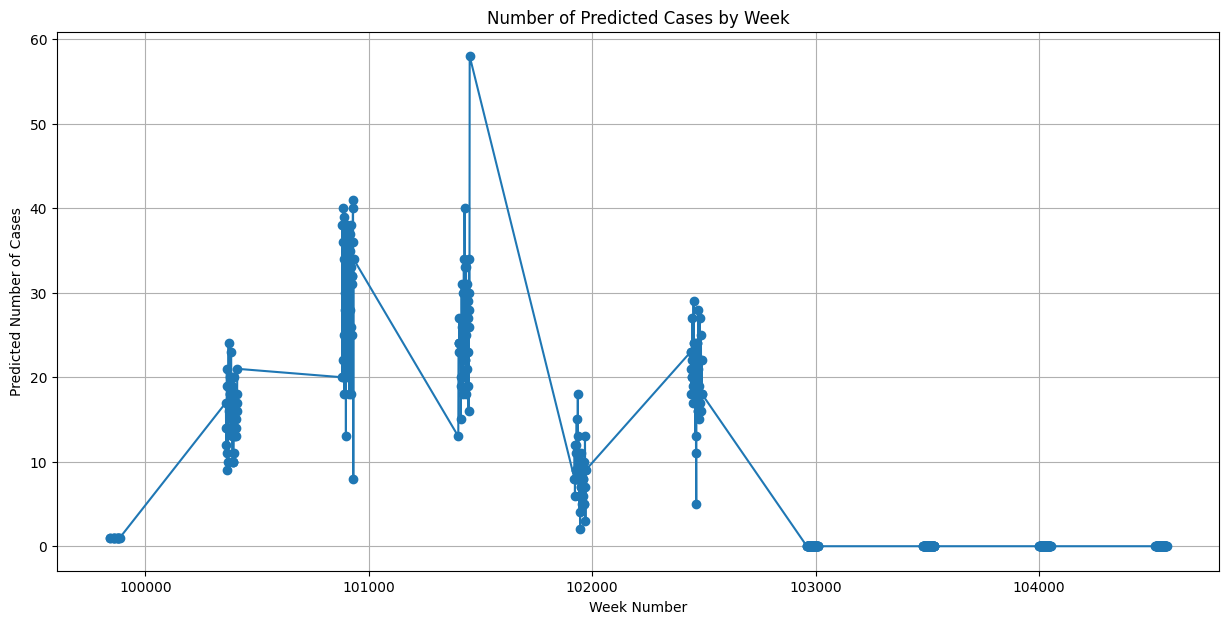

time: 1.15 s (started: 2024-04-30 21:19:44 +00:00)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

original_data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')

original_data['end_date'] = pd.to_datetime(original_data['end_date'])

X_test_with_dates = X_test.merge(original_data[['end_date']], left_index=True, right_index=True, how='left')

X_test_with_dates['predicted_cases'] = y_pred

X_test_with_dates['week'] = X_test_with_dates['end_date'].dt.isocalendar().week
X_test_with_dates['year'] = X_test_with_dates['end_date'].dt.year

weekly_predictions = X_test_with_dates.groupby(['year', 'week'])['predicted_cases'].sum().reset_index()

plt.figure(figsize=(15, 7))
plt.plot(weekly_predictions['week'] + weekly_predictions['year'] * 52, weekly_predictions['predicted_cases'], marker='o')
plt.title('Number of Predicted Cases by Week')
plt.xlabel('Week Number')
plt.ylabel('Count of Predicted Cases (per 100,000)')
plt.grid(True)
plt.show()


From this chart alone we can see that the majority of cases happen in a certain time frame or week number. We can further show that in a density chart

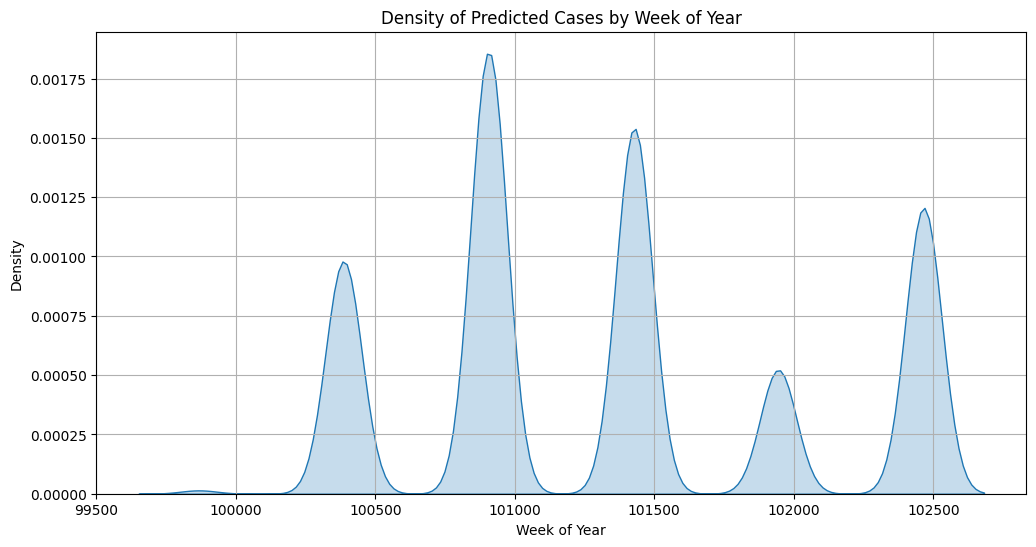

time: 1.01 s (started: 2024-04-30 21:21:01 +00:00)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

original_data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')
original_data['end_date'] = pd.to_datetime(original_data['end_date'])


X_test_with_dates = X_test.merge(original_data[['end_date']], left_index=True, right_index=True, how='left')
if X_test_with_dates['end_date'].isnull().any():
    print("Some dates were not merged correctly. Check indices or merging keys.")

X_test_with_dates['predicted_cases'] = y_pred

X_test_with_dates['week_of_year'] = X_test_with_dates['end_date'].dt.isocalendar().week + X_test_with_dates['end_date'].dt.year * 52

plt.figure(figsize=(12, 6))
repeated_weeks = X_test_with_dates.loc[X_test_with_dates.index.repeat(X_test_with_dates['predicted_cases'])]['week_of_year']
sns.kdeplot(repeated_weeks, bw_adjust=0.5, fill=True)
plt.title('Density of Predicted Cases by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Density')
plt.grid(True)
plt.show()


Now we want to know what weeks typically show more cases accross the set. So if take all the prediction place and pool numbers we can show the predicited cases. Even more so we can use the orginal epiweeks as a x variable as orginally intended.


First in the predictions lets see what weeks across all the sum of the predicitions by week

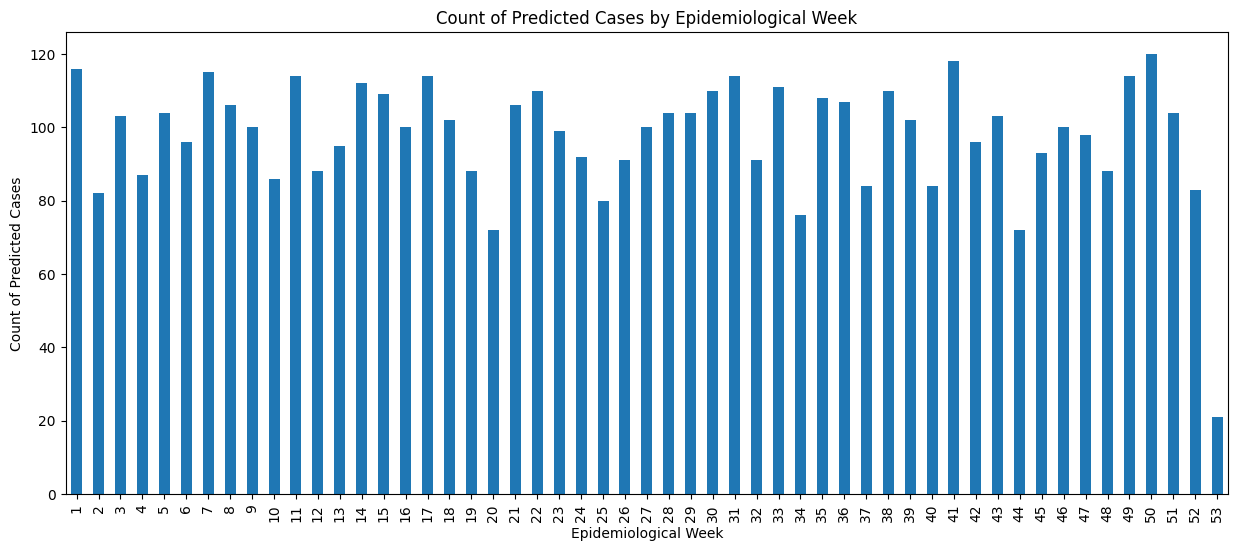

time: 1.51 s (started: 2024-04-30 21:27:17 +00:00)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from epiweeks import Week

original_data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')
original_data['end_date'] = pd.to_datetime(original_data['end_date'])


original_data.loc[X_test.index, 'predicted_cases'] = y_pred

original_data['epiweek'] = original_data['end_date'].apply(lambda x: Week.fromdate(x).week)

epiweek_counts = original_data.groupby('epiweek')['predicted_cases'].sum()

plt.figure(figsize=(15, 6))
epiweek_counts.plot(kind='bar')

plt.title('Count of Predicted Cases by Epidemiological Week')
plt.xlabel('Epidemiological Week')
plt.ylabel('Count of Predicted Cases (per 100,000)')

plt.show()


Now lets see the avg amount of cases by Epidemiological Week.

We can see on avg the 4th week of the year tends to have more cases. we ignore the 53 week it happens less so the avg will be higher

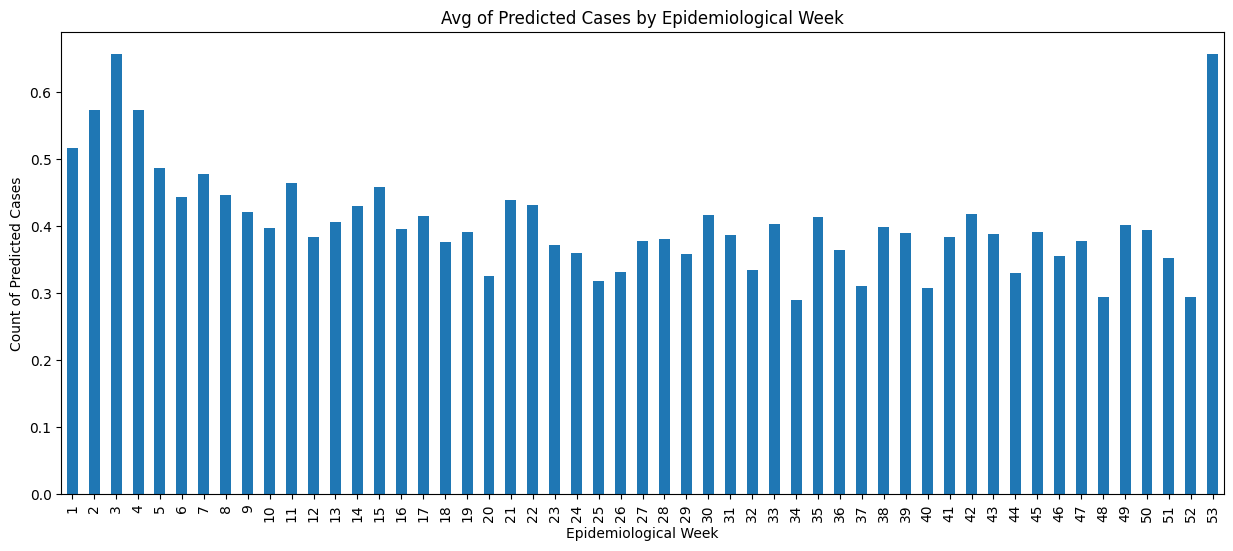

time: 2.19 s (started: 2024-04-30 21:30:40 +00:00)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from epiweeks import Week

original_data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')
original_data['end_date'] = pd.to_datetime(original_data['end_date'])


original_data.loc[X_test.index, 'predicted_cases'] = y_pred

original_data['epiweek'] = original_data['end_date'].apply(lambda x: Week.fromdate(x).week)

epiweek_counts = original_data.groupby('epiweek')['predicted_cases'].mean()

plt.figure(figsize=(15, 6))
epiweek_counts.plot(kind='bar')

plt.title('Avg of Predicted Cases by Epidemiological Week')
plt.xlabel('Epidemiological Week')
plt.ylabel('Count of Predicted Cases (per 100,000)')

plt.show()


Lastly, the goal was to show statistics for a given state lets do that. In the same format as before sum followed by the mean. Any state can be placed here I was Texas due to the large population

<ipython-input-48-6c3c2ce90df9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Texas_data['predicted_cases'] = 0
<ipython-input-48-6c3c2ce90df9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Texas_data['epiweek'] = Texas_data['end_date'].apply(lambda x: Week.fromdate(x).week)


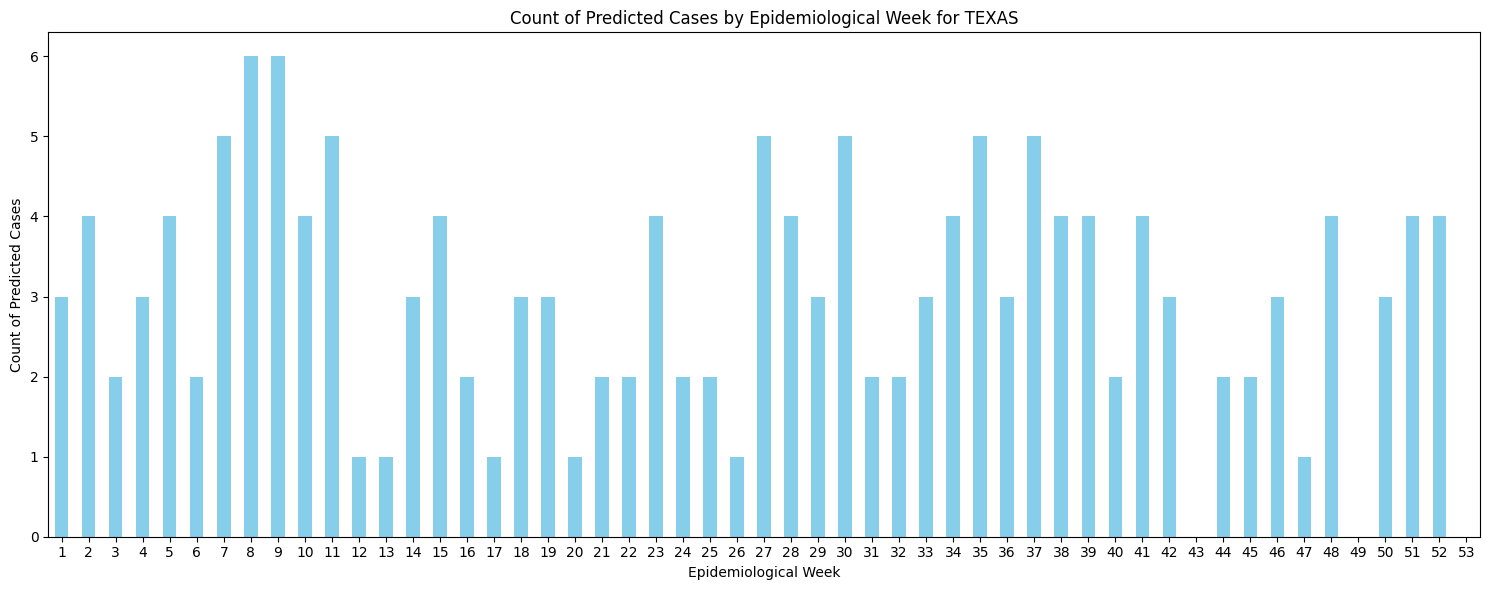

time: 1.32 s (started: 2024-04-30 21:35:11 +00:00)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from epiweeks import Week

original_data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')
original_data['end_date'] = pd.to_datetime(original_data['end_date'])

Texas_data = original_data[original_data['Name'] == 'TEXAS']

Texas_y_pred = y_pred[X_test['Name'] == 'TEXAS']


Texas_data['predicted_cases'] = 0
Texas_data.loc[X_test[X_test['Name'] == 'TEXAS'].index, 'predicted_cases'] = Texas_y_pred

Texas_data['epiweek'] = Texas_data['end_date'].apply(lambda x: Week.fromdate(x).week)

counts = Texas_data.groupby('epiweek')['predicted_cases'].sum()


plt.figure(figsize=(15, 6))
counts.plot(kind='bar', color='skyblue')


plt.title('Count of Predicted Cases by Epidemiological Week for TEXAS')
plt.xlabel('Epidemiological Week')
plt.ylabel('Count of Predicted Cases (per 100,000)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


<ipython-input-49-4bca073d62e8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Texas_data['predicted_cases'] = 0
<ipython-input-49-4bca073d62e8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Texas_data['epiweek'] = Texas_data['end_date'].apply(lambda x: Week.fromdate(x).week)


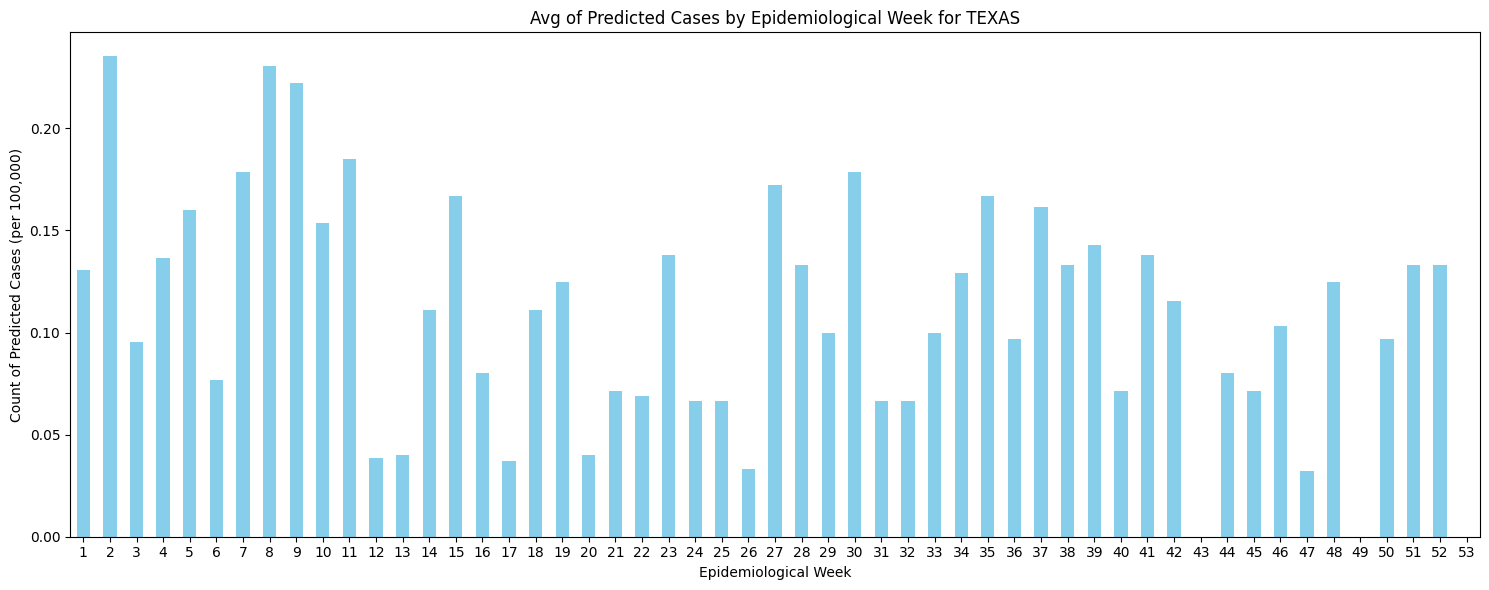

time: 1.21 s (started: 2024-04-30 21:36:47 +00:00)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from epiweeks import Week

original_data = pd.read_csv('/content/drive/MyDrive/DataScience1/HeribertoArgil_Project/capstone/joined_data.csv')
original_data['end_date'] = pd.to_datetime(original_data['end_date'])

Texas_data = original_data[original_data['Name'] == 'TEXAS']

Texas_y_pred = y_pred[X_test['Name'] == 'TEXAS']


Texas_data['predicted_cases'] = 0
Texas_data.loc[X_test[X_test['Name'] == 'TEXAS'].index, 'predicted_cases'] = Texas_y_pred

Texas_data['epiweek'] = Texas_data['end_date'].apply(lambda x: Week.fromdate(x).week)

counts = Texas_data.groupby('epiweek')['predicted_cases'].mean()


plt.figure(figsize=(15, 6))
counts.plot(kind='bar', color='skyblue')


plt.title('Avg of Predicted Cases by Epidemiological Week for TEXAS')
plt.xlabel('Epidemiological Week')
plt.ylabel('Count of Predicted Cases (per 100,000)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


# Conclusion

At the start of the project we set off to find hotspots based on diseases and ended with something more percise and useful for anyone in any comunity in the US. Though with more data available and specifying geolocations we can truly target more useful data by predicting what counties are at most risk.

As well as more data on various diseases and vaccinations will only help improve this model to be more well rounded.